## ECON 570 
## Assignment 2
## Instructor: Ida Johnsson
## Name: Yantong Li

### 1. Simulate a DGP where the outcome of interest depends on a randomly assigned treatment and some observed covariates. How does your estimate of the treatment effect parameter compare in the following two cases
#### a. You do not control for any covariates
#### b. You control for all the covariates that affect the outcome

In [51]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import graphviz as gr
import statsmodels.formula.api as smf

### a. You do not control for any covariates

#### suppose our model is the following:
$Y_i = a*T_i+e_i$, where $e_i \sim N(0,\sigma^2)$

$a$ is the treatment effect, and treatment takes values 0 if not receiving it or 1 if receiving it.

### simulate the DGP:

In [328]:
def fn_generate_cov(dim):
    acc  = []
    for i in range(dim):
        row = np.ones((1,dim)) * corr
        row[0][i] = 1
        acc.append(row)
    return np.concatenate(acc,axis=0)

def fn_generate_multnorm(nobs,corr,nvar):

    mu = np.zeros(nvar)
    std = (np.abs(np.random.normal(loc = 1, scale = .5,size = (nvar,1))))**(1/2)
    # generate random normal distribution
    acc = []
    for i in range(nvar):
        acc.append(np.reshape(np.random.normal(mu[i],std[i],nobs),(nobs,-1)))
    
    normvars = np.concatenate(acc,axis=1)

    cov = fn_generate_cov(nvar)
    C = np.linalg.cholesky(cov)

    Y = np.transpose(np.dot(C,np.transpose(normvars)))

    return Y

def fn_generate_data(a,N,p,p0,corr,conf = True,flagX = False):
    
    nvar = p+2
    corr = 0.5 

    if conf==False:
        conf_mult = 0 
    else:
        conf_mult = 1
        
    allX = fn_generate_multnorm(N,corr,nvar)
    W0 = allX[:,0].reshape([N,1]) 
    C = allX[:,1].reshape([N,1]) 
    X = allX[:,2:] 
    
    T = fn_randomize_treatment(N) 
    err = np.random.normal(0,1,[N,1])
    beta0 = np.random.normal(5,5,[p,1])
    
    beta0[p0:p] = 0
    Yab = a*T+X@beta0+conf_mult*0.6*C+err
    if flagX==False:
        return (Yab,T)
    else:
        return (Yab,T,X)

def fn_randomize_treatment(N,p=0.5):
    
    treated = random.sample(range(N), round(N*p))
    return np.array([(1 if i in treated else 0) for i in range(N)]).reshape([N,1])

def fn_ahat_means(Yt,Yc):
    nt = len(Yt)
    nc = len(Yc)
    ahat = np.mean(Yt)-np.mean(Yc)
    se_ahat = (np.var(Yt,ddof=1)/nt+np.var(Yc,ddof=1)/nc)**(1/2)
    return (ahat,se_ahat)

def fn_run_experiments(a,Nrange,p,p0,corr,conf,flagX=False):
    n_values = []
    ahats = []
    sehats = []
    lb = []
    ub = []
    for N in tqdm(Nrange):
        n_values = n_values + [N]
        if flagX==False:
            Yexp,T = fn_generate_data(a,N,p,p0,corr,conf,flagX)
            Yt = Yexp[np.where(T==1)[0],:]
            Yc = Yexp[np.where(T==0)[0],:]
            ahat,se_ahat = fn_ahat_means(Yt,Yc)            
        elif flagX==1:
            
            Yexp,T,X = fn_generate_data(a,N,p,p0,corr,conf,flagX)
            Xobs = X[:,:p0]
            covars = np.concatenate([T,Xobs],axis = 1)
            mod = sm.OLS(Yexp,covars)
            res = mod.fit()
            ahat = res.params[0]
            se_ahat = res.HC1_se[0]
        elif flagX==2:
            
            Yexp,T,X = fn_generate_data(a,N,p,p0,corr,conf,flagX)
            Xobs1 = X[:,:np.int(p0/2)]
            Xobs2 = X[:,-np.int(p0/2):]
            covars = np.concatenate([T,Xobs1,Xobs2],axis = 1)
            mod = sm.OLS(Yexp,covars)
            res = mod.fit()
            ahat = res.params[0]
            se_ahat = res.HC1_se[0]
            
        ahats = ahats + [ahat]
        sehats = sehats + [se_ahat]    
        lb = lb + [ahat-1.96*se_ahat]
        ub = ub + [ahat+1.96*se_ahat]
        
    return (n_values,ahats,sehats,lb,ub)

def fn_bias_rmse_size(theta0,thetahat,se_thetahat,cval = 1.96):
    """
    theta0 - true parameter value
    thetatahat - estimated parameter value
    se_thetahat - estiamted se of thetahat
    
    """
    b = thetahat - theta0
    bias = np.mean(b)
    rmse = np.sqrt(np.mean(b**2))
    tval = b/se_thetahat 
    size = np.mean(1*(np.abs(tval)>cval))
    return (bias,rmse,size)

In [3]:
# Simulate the DGP

a = 3
corr = .5
conf=False # No confounders
p = 10
p0 = 0 # number of covariates used in the DGP


In [4]:
np.random.seed(24)
N = 100
Yexp,T = fn_generate_data(a,N,10,0,corr,conf = False)
Yt = Yexp[np.where(T==1)[0],:]
Yc = Yexp[np.where(T==0)[0],:]
ahat,se_ahat = fn_ahat_means(Yt,Yc)

In [5]:
ahat,se_ahat

(2.955725876113058, 0.17853876671619115)

In [6]:
const = np.ones([N,1])

In [7]:
model = sm.OLS(Yexp,np.concatenate([T,const],axis = 1))
res = model.fit()
# res.summary()
print(res.summary())
res.params[0], res.HC1_se[0]

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.737
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     274.1
Date:                Tue, 05 Apr 2022   Prob (F-statistic):           3.80e-30
Time:                        13:46:39   Log-Likelihood:                -129.53
No. Observations:                 100   AIC:                             263.1
Df Residuals:                      98   BIC:                             268.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.9557      0.179     16.555      0.0

(2.955725876113057, 0.17853876671619118)

From above, we can see that when you just run the experiment once, the estimated coefficient could be misleading because when the noise contained in $e_i$ is big, we cannot tell whether the estimated coefficient is a good one or not. Therefore, we need to run a Monte Carlo simulation to see the distribution of estimated parameters and tell whether the model produces good enough estimation.

### Running a Monte Carlo simulation:

In [8]:
# Running a Monte Carlo simulation:

estDict = {}
R = 2000
for N in [100,1000]:
    ahats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp,T = fn_generate_data(a,N,10,0,corr,conf)
        Yt = Yexp[np.where(T==1)[0],:]
        Yc = Yexp[np.where(T==0)[0],:]
        ahat,se_ahat = fn_ahat_means(Yt,Yc)
        ahats = ahats + [ahat]
        sehats = sehats + [se_ahat]
    estDict[N] = {
        'ahat':np.array(ahats).reshape([len(ahats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
        
    }

100%|██████████████████████████████████████| 2000/2000 [00:14<00:00, 139.93it/s]


In [9]:
a0 = a*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(a0,results['ahat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=0.0003473142311447819, RMSE=0.2009536478523862, size=0.0575
N=1000: bias=0.00023021966964751806, RMSE=0.06341891750439807, size=0.054


### DAG to illustrate the DGP:

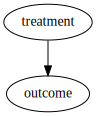

In [10]:
g = gr.Digraph()

g.edge("treatment", "outcome")
g

### real-life situation that might be consistent with the DGP:
For example, there is a randomly assigned employment training program that we want to investigate its effect on unemployment rate. Suppose T = 1 is someone participating in the program and T = 0 is not. As we run a regression of employment training program on unemployment rate, we can find the coefficient of employment training program as the treatment effect.

### b. You control for all the covariates that affect the outcome

#### suppose our model is the following:
$y_i = a*T_i+\beta'*x_i+e_i$, where $e_i \sim N(0,\sigma^2)$

$a$ is the treatment effect, treatment takes values 0 or 1, and now we have covariate $x_i$ and its coefficient is $\beta'$

### simulate the DGP:

In [11]:
# Simulate the DGP

a = 3
corr = .5
conf=False
p = 100
p0 = 50 # number of covariates used in the DGP
Nrange = range(100,1000,2) 
flagX = 1
(nvalues2,ahats2,sehats2,lb2,ub2) = fn_run_experiments(a,Nrange,p,p0,corr,conf,flagX)


100%|█████████████████████████████████████████| 450/450 [00:05<00:00, 75.94it/s]


In [12]:
np.random.seed(24)
N = 100
Yexp,T = fn_generate_data(a,N,10,0,corr,conf = False)
Yt = Yexp[np.where(T==1)[0],:]
Yc = Yexp[np.where(T==0)[0],:]
ahat,se_ahat = fn_ahat_means(Yt,Yc)

In [13]:
ahat,se_ahat

(2.9123216622596577, 0.17837502475579603)

In [14]:
const = np.ones([N,1])

In [15]:
model = sm.OLS(Yexp,np.concatenate([T,const],axis = 1))
res = model.fit()
# res.summary()
print(res.summary())
res.params[0], res.HC1_se[0]

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.731
Model:                            OLS   Adj. R-squared:                  0.728
Method:                 Least Squares   F-statistic:                     266.6
Date:                Tue, 05 Apr 2022   Prob (F-statistic):           1.03e-29
Time:                        13:47:02   Log-Likelihood:                -129.44
No. Observations:                 100   AIC:                             262.9
Df Residuals:                      98   BIC:                             268.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.9123      0.178     16.327      0.0

(2.912321662259658, 0.17837502475579603)

### Running a Monte Carlo simulation:

In [16]:
# Running a Monte Carlo simulation:

estDict = {}
R = 2000
for N in [100,1000]:
    ahats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp,T = fn_generate_data(a,N,10,0,corr,conf)
        Yt = Yexp[np.where(T==1)[0],:]
        Yc = Yexp[np.where(T==0)[0],:]
        ahat,se_ahat = fn_ahat_means(Yt,Yc)
        ahats = ahats + [ahat]
        sehats = sehats + [se_ahat]
    estDict[N] = {
        'ahat':np.array(ahats).reshape([len(ahats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
        
    }

100%|██████████████████████████████████████| 2000/2000 [00:15<00:00, 129.35it/s]


In [17]:
a0 = a*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(a0,results['ahat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=0.0006431858511456492, RMSE=0.20431044407726498, size=0.063
N=1000: bias=0.0005962154582255686, RMSE=0.061963264053890944, size=0.0505


including covariates that affect the outcome Y improves precision of the estimate because as we control for more reasonable variables, we are able to discover the true estimate of the treatment effect without confounding factors.

### DAG to illustrate the DGP:

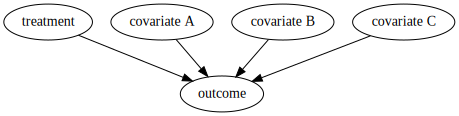

In [18]:
g = gr.Digraph()

g.edge("treatment", "outcome")
g.edge("covariate A", "outcome")
g.edge("covariate B", "outcome")
g.edge("covariate C", "outcome")

g

### real-life situation that might be consistent with the DGP:
Using the previous example, there is a randomly assigned employment training program that we want to investigate its effect on unemployment rate. Suppose 1 is someone participating in the program and 0 is not. As we include in the regression some covariates that do affect the outcome of interest, such as family background, age, willingness to learn, we can be more accurate in the estimate of the treatment effect because we now control for useful covariates that help explain the outcome and reduce the variance of the estimation.

### 2. Simulate a DGP with a confounder (common cause)
#### a. You fail to control for the confounder
#### b. You do control for the confounder

### a. You fail to control for the confounder

#### suppose the model looks like this: 
$Y_i = a + b*T_i+e_i$, where $e_i \sim N(0,\sigma^2)$

Suppose we are investigating the effect of job training program on days for people to find a job. We expect to find a negative relationship between the program and days to find a job. Let's consider the scenario in 2 job training program schools, and suppose in the first school, 90% of students receive the program at random and 10% don't; in the second school, the inverse is true. It is also known that the school which gives 90% of students the job training program usually contains more people that are incapable of finding a job at the first place (lower education levels, coming from lower income families, etc.). 

#### first we simulate a DGP: 

where:

school is the variable indicating what school the student is coming from 

treatment is the job training program

ability is the students' ability to find a job without the program

days is the days people find a job

In [61]:
np.random.seed(24)
n = 80

school = np.random.binomial(1, 0.5, n)

treatment = np.where(school.astype(bool),
                     np.random.binomial(1, 0.9, n),
                     np.random.binomial(1, 0.1, n))

ability = np.where(school.astype(bool), 
                    np.random.normal(25, 7, n),
                    np.random.normal(20, 7, n))

days = np.random.normal(10 + -3*treatment + 1*ability, 7).astype(int)

school = pd.DataFrame(dict(school=school,
                             treatment=treatment,
                             ability=ability,
                             days=days))

school.to_csv("school_treatment.csv", index=False)

In [62]:
school = pd.read_csv(r'/Users/yantongli/Desktop/Graduate School/Spring 2022/ECON570/ECON570_A2_Yantong_Li/school_treatment.csv')
school.head()

,school,treatment,ability,days
0,1,1,38.561265,58
1,1,1,25.070476,39
2,1,1,25.423358,31
3,0,0,20.844365,39
4,0,0,17.665910,11


In [63]:
# run a regression of days on treatment
sch_nc = smf.ols('days ~ treatment', data=school).fit()
sch_nc.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   days   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.176
Date:                Thu, 07 Apr 2022   Prob (F-statistic):              0.282
Time:                        17:14:21   Log-Likelihood:                -305.26
No. Observations:                  80   AIC:                             614.5
Df Residuals:                      78   BIC:                             619.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     27.5333      2.032     13.552      0.000      23.489      31.578
treatment      2.7867      2.570      1.084      0.282      -2.329       7.903
==============================================================================
Omnibus:                        0.209   Durbin-Watson:                   1.822
Prob(Omnibus):                  0.901   Jarque-Bera (JB):                0.395
Skew:                           0.054   Prob(JB):                        0.821
Kurtosis:                       2.673   Cond. No.                         3.03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

As we can see, we get counterintuitive results of the treatment effect, where we see the job training program actually
increases the days people find a job. This is the problem when we don't include any confounders in the regression

### b. You do control for the confounder

Now we include ability in our model to see how the treatment effect changes

In [64]:
sch_c = smf.ols('days ~ treatment + ability', data=school).fit()
sch_c.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   days   R-squared:                       0.559
Model:                            OLS   Adj. R-squared:                  0.548
Method:                 Least Squares   F-statistic:                     48.83
Date:                Thu, 07 Apr 2022   Prob (F-statistic):           2.02e-14
Time:                        17:14:26   Log-Likelihood:                -273.09
No. Observations:                  80   AIC:                             552.2
Df Residuals:                      77   BIC:                             559.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.4966      2.730      1.647      0.104      -0.940       9.933
treatment     -4.2833      1.876     -2.283      0.025      -8.019      -0.548
ability        1.2520      0.128      9.750      0.000       0.996       1.508
==============================================================================
Omnibus:                        4.061   Durbin-Watson:                   2.190
Prob(Omnibus):                  0.131   Jarque-Bera (JB):                3.967
Skew:                          -0.538   Prob(JB):                        0.138
Kurtosis:                       2.823   Cond. No.                         75.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Now we see that the treatment effect becomes negative, which is what we would expect

### Running a Monte Carlo simulation:

### DAG to illustrate the DGP:

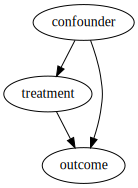

In [69]:
g = gr.Digraph()

g.edge("confounder", "treatment")
g.edge("confounder", "outcome")

g.edge("treatment", "outcome")

g

### real life situation that might be consistent with the DGP
For example, if we are running a regression of education on wage, we might get a biased estimate of the education coefficient because there might be confounders that we should have included in the regression such as the person's family wealth, which influences both the person's education level and his or her wage. Usually, wealthier families are more willing to invest in their children's education; and at the same time, wealthier parents can provide their children with better networking opportunities that can potentially be tied to higher wages of their children. Therefore, we need to include confounders like this in the regression in order to extract the sole effect of education on wage.

### 3. Simulate a DGP with selection bias into the treatment (variable in between the path from the treatment to the outcome)
#### a. You control for the variable in between the path from cause to effect
#### b. You do not control for the variable in between the path from cause to effect

Suppose we want to estimate the effect of a website's online advertisement on purchasing behavior. The advertiseent is randomly displayed on the website. We run a regression of purchase on ad(equal to 1 if the customer sees the ad and 0 if not), together with the customer's income level and age. Suppose customers with a higher income tend to purchase more and older people tend to buy less. We then also want to add two more variables "clicked" (with 1 indicating that the customer sees the add and clicks on it, 0 indicating that the customer sees the add and doesn't click on it) and "browse" (with 1 indicating that the customer browses the product after clicking on the ad, 0 indicating that the customer doesn't browse after clicking). We should see a selection bias when we include "clicked" and "browse" in our regression because these two variables are in between the path from ad to purchase.

### Simulate a DGP: 

In [317]:
np.random.seed(24)
n = 5000
ad = np.random.binomial(1, 0.5, n)

income_level = np.random.gamma(18, 100, n)
age = np.random.normal(30, 5, n)

clicked = np.random.normal(5 + 0.001*income_level - 0.01*age, 2)
clicked = (clicked > 4).astype(float) * ad

browse = np.random.normal(30 +(-0.003*income_level - 0.01*age), 7) * 2 * clicked
browse = (browse > 40).astype(float)

purchase = (np.random.normal(1000 + 0.3*income_level - 5*age + 15*browse + ad, 75).astype(int) // 10) * 10

data = pd.DataFrame(dict(purchase=purchase,
                         ad=ad,
                         clicked=clicked,
                         browse=browse,
                         income_level=income_level,
                         age=age))

data.to_csv("purchase.csv", index=False)

In [318]:
purchase = pd.read_csv(r'/Users/yantongli/Desktop/Graduate School/Spring 2022/ECON570/ECON570_A2_Yantong_Li/purchase.csv')
purchase.head()

,purchase,ad,clicked,browse,income_level,age
0,1790,1,1.0,0.0,2726.975213,29.614943
1,1210,1,1.0,1.0,940.901958,34.755737
2,1540,1,1.0,0.0,1962.053918,20.328495
3,1410,0,0.0,0.0,2103.144984,28.120141
4,1360,0,0.0,0.0,1628.324124,28.126554


### a. You control for the variable in between the path from cause to effect

In [325]:
ad_1 = smf.ols('purchase ~ ad + income_level + age + clicked + browse', data=data).fit()
ad_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               purchase   R-squared:                       0.743
Model:                            OLS   Adj. R-squared:                  0.743
Method:                 Least Squares   F-statistic:                     2884.
Date:                Fri, 08 Apr 2022   Prob (F-statistic):               0.00
Time:                        21:29:40   Log-Likelihood:                -28652.
No. Observations:                5000   AIC:                         5.732e+04
Df Residuals:                    4994   BIC:                         5.736e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      990.8970      7.901    125.408      0.000     975.407    1006.387
ad               3.4357      4.651      0.739      0.460      -5.681      12.553
income_level     0.2993      0.003    117.520      0.000       0.294       0.304
age             -4.7616      0.211    -22.617      0.000      -5.174      -4.349
clicked         -3.4490      5.421     -0.636      0.525     -14.077       7.179
browse           8.1394      3.643      2.234      0.026       0.997      15.282
==============================================================================
Omnibus:                        1.493   Durbin-Watson:                   1.987
Prob(Omnibus):                  0.474   Jarque-Bera (JB):                1.500
Skew:                           0.042   Prob(JB):                        0.472
Kurtosis:                       2.991   Cond. No.                     1.40e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.4e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### b. You do not control for the variable in between the path from cause to effect

In [326]:
ad_2 = smf.ols('purchase ~ ad + income_level + age', data=data).fit()
ad_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               purchase   R-squared:                       0.743
Model:                            OLS   Adj. R-squared:                  0.742
Method:                 Least Squares   F-statistic:                     4802.
Date:                Fri, 08 Apr 2022   Prob (F-statistic):               0.00
Time:                        21:29:43   Log-Likelihood:                -28655.
No. Observations:                5000   AIC:                         5.732e+04
Df Residuals:                    4996   BIC:                         5.734e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      992.0052      7.869    126.071      0.000     976.579    1007.431
ad               5.6612      2.111      2.681      0.007       1.522       9.800
income_level     0.2989      0.003    118.222      0.000       0.294       0.304
age             -4.7737      0.210    -22.678      0.000      -5.186      -4.361
==============================================================================
Omnibus:                        1.604   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.448   Jarque-Bera (JB):                1.617
Skew:                           0.044   Prob(JB):                        0.445
Kurtosis:                       2.987   Cond. No.                     1.37e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.37e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

We can see that when we do not control for the variable in between the path from cause to effect, the coefficient of ad is significant with a p-value of 0.007; when we control for the variable in between the path from cause to effect, the coefficient of ad is not significant with a p-value of 0.46. This is because when we control for the clicked variable, we create a selection bias into the regression that biases our estimate. People who clicked on the ad and people who don't should be different types of customers in the first place.

### Running a Monte Carlo simulation:

### DAG to illustrate the DGP:

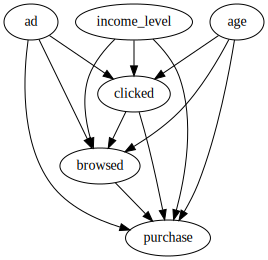

In [331]:
g = gr.Digraph()

g.edge("ad", "purchase")
g.edge("ad", "clicked")
g.edge("ad", "browsed")
g.edge("clicked", "purchase")
g.edge("clicked", "browsed")
g.edge("browsed", "purchase")


g.edge("income_level", "browsed")
g.edge("income_level", "purchase")
g.edge("income_level", "clicked")
g.edge("age", "purchase")
g.edge("age", "clicked")
g.edge("age", "browsed")


g

### real life situation that might be consistent with the DGP
As we can see from the illustration above, we find that there is a selection bias present when we control for variables "clicked" and "browse", which is in between the path from ad to purchase.

$
E[Y_0|T=0, browsed=0] > E[Y_0|T=1, browsed=0]
$

$
E[Y_0|T=0, browsed=1] > E[Y_0|T=1, browsed=1]
$

$
E[Y_0|T=0, clicked=0] > E[Y_0|T=1, clicked=0]
$

$
E[Y_0|T=0, clicked=1] > E[Y_0|T=1, clicked=1]
$

From the first equation, we can see that those who didn't see the ad and browsed are better than those who saw the ad and didn't browse. That is because, if the treatment "ad" has a positive effect on purchase, those that didn't browse even after having seen the ad tend to buy less compared to those that also didn't browse but also didn't see the ad. As for the second equation, those that browsed even without having seen the ad tend to buy more than those that browsed but saw the ad. This selection bias means  the people who clicked and browsed different in nature from those who didn't.